tt: [ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.50505051
  0.60606061  0.70707071  0.80808081  0.90909091  1.01010101  1.11111111
  1.21212121  1.31313131  1.41414141  1.51515152  1.61616162  1.71717172
  1.81818182  1.91919192  2.02020202  2.12121212  2.22222222  2.32323232
  2.42424242  2.52525253  2.62626263  2.72727273  2.82828283  2.92929293
  3.03030303  3.13131313  3.23232323  3.33333333  3.43434343  3.53535354
  3.63636364  3.73737374  3.83838384  3.93939394  4.04040404  4.14141414
  4.24242424  4.34343434  4.44444444  4.54545455  4.64646465  4.74747475
  4.84848485  4.94949495  5.05050505  5.15151515  5.25252525  5.35353535
  5.45454545  5.55555556  5.65656566  5.75757576  5.85858586  5.95959596
  6.06060606  6.16161616  6.26262626  6.36363636  6.46464646  6.56565657
  6.66666667  6.76767677  6.86868687  6.96969697  7.07070707  7.17171717
  7.27272727  7.37373737  7.47474747  7.57575758  7.67676768  7.77777778
  7.87878788  7.97979798  8.08080808  8.1818181

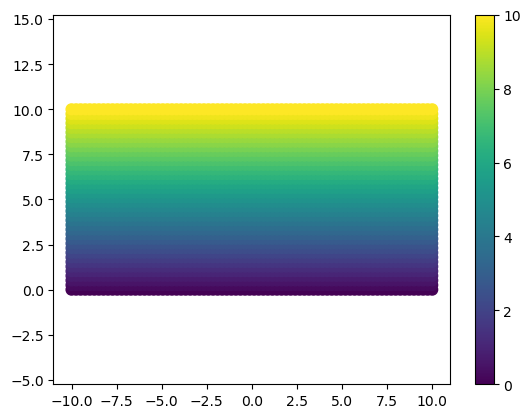

In [3]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import h5py

np.random.seed(0)

# filename = "uniform_inflow.h5"
filename = "linear_inflow.h5"

y_min = -10.0
y_max = 10.0
ny = 80 #40

z_min = 0.0
z_max = 10.0
nz = 40 #20

yy = np.linspace(y_min, y_max, ny)
zz = np.linspace(z_min, z_max, nz)

t_final = 10.0
t_steps = 100 # 50

tt = np.linspace(0, t_final, t_steps)

print("tt:", tt)

yy_mesh, zz_mesh = np.meshgrid(yy, zz)

# u = 7.0 + 0.5*np.cos(2*2.0*np.pi/(y_max-y_min)*np.add.outer(tt, np.sqrt(yy_mesh**2+zz_mesh**2))).reshape(t_steps, nz, -1)
# v = np.cos(2*2.0*np.pi/(y_max-y_min)*np.add.outer(tt, yy_mesh)).reshape(t_steps, nz, -1)
# w = np.cos(2*2.0*np.pi/(z_max-z_min)*np.add.outer(tt, zz_mesh)).reshape(t_steps, nz, -1)

u_ref = 10.0
# u = u_ref * np.ones((t_steps, ny, nz)).reshape(t_steps, nz, -1)
# v = np.zeros((t_steps, ny, nz)).reshape(t_steps, nz, -1)
# w = np.zeros((t_steps, ny, nz)).reshape(t_steps, nz, -1)

u_linear = (u_ref/zz[-1]) * zz

u = np.tile(np.tile(u_linear[:, np.newaxis], (1, ny)), (t_steps, 1, 1))
v = np.zeros((t_steps, nz, ny)) #.reshape(t_steps, nz, -1)
w = np.zeros((t_steps, nz, ny)) #.reshape(t_steps, nz, -1)


with h5py.File(filename, "w") as fp:
    fp.create_dataset("time_index", shape=(t_steps,))
    fp["time_index"][:] = tt
    
    fp.create_dataset("y_coordinates", shape=(ny,))
    fp["y_coordinates"][:] = yy
        
    fp.create_dataset("z_coordinates", shape=(nz,))
    fp["z_coordinates"][:] = zz
        
    fp.create_dataset("u", shape=(t_steps, nz, ny))
    fp["u"][:] = u[:]
    
    fp.create_dataset("v", shape=(t_steps, nz, ny))
    fp["v"][:] = v[:]
    
    fp.create_dataset("w", shape=(t_steps, nz, ny))
    fp["w"][:] = w[:]
        
    
with h5py.File(filename, "r") as fp:
    for key, val in fp.items():
        print(key, val.shape, val.dtype)
        
    yy_mesh, zz_mesh = np.meshgrid(fp["y_coordinates"][:], fp["z_coordinates"][:])
    cbar = plt.scatter(yy_mesh, zz_mesh, c=fp["u"][-1, :, :], s=60) #, vmin=0.5, vmax=2.7)
    plt.colorbar(cbar)
    plt.axis("equal")

In [2]:
pwd

'/Users/bstanisl/Documents/repos/PVade/examples/synthetic_turbulent_inflow_read_time_bcs'

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151516 0.16161616 0.17171717
 0.18181819 0.1919192  0.2020202  0.21212122 0.22222222 0.23232323
 0.24242425 0.25252524 0.26262626 0.27272728 0.28282827 0.2929293
 0.3030303  0.3131313  0.32323232 0.33333334 0.34343433 0.35353535
 0.36363637 0.37373737 0.3838384  0.3939394  0.4040404  0.41414142
 0.42424244 0.43434343 0.44444445 0.45454547 0.46464646 0.47474748
 0.4848485  0.4949495  0.5050505  0.5151515  0.5252525  0.53535354
 0.54545456 0.5555556  0.56565654 0.57575756 0.5858586  0.5959596
 0.6060606  0.61616164 0.6262626  0.6363636  0.64646465 0.65656567
 0.6666667  0.67676765 0.68686867 0.6969697  0.7070707  0.7171717
 0.72727275 0.7373737  0.74747473 0.75757575 0.7676768  0.7777778
 0.7878788  0.7979798  0.8080808  0.8181818  0.82828283 0.83838385
 0.8484849  0.85858583 0.86868685 0.8787879  0.8888889  0.8989899


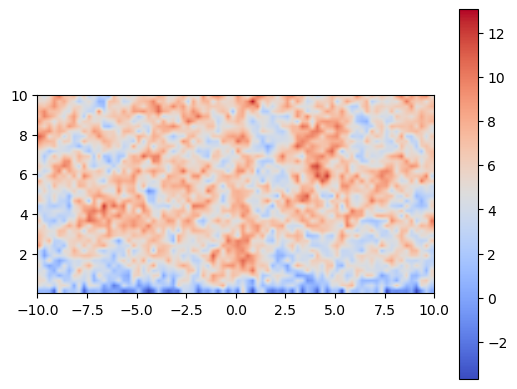

In [4]:
with h5py.File("../../input/pct_turb_ny80_nz40_unconstrained_1s_dt01.h5", "r") as fp:   
# with h5py.File(filename, "r") as fp:
    print(fp["time_index"][:])  
    # yy_mesh, zz_mesh = np.meshgrid(fp["y_coordinates"][:], fp["z_coordinates"][:])
    # cbar = plt.scatter(yy_mesh, zz_mesh, c=fp["u"][0, :, :], s=60) #, vmin=0.5, vmax=2.7)
    # plt.colorbar(cbar)
    # plt.axis("equal")

    y_fp = fp["y_coordinates"][:]
    z_fp = fp["z_coordinates"][:]

    data = {}
    data['u'] = fp["u"][:]
    data['v'] = fp["v"][:]
    data['w'] = fp["w"][:]

    fig, ax = plt.subplots()
    plt.imshow(fp["u"][0, :, :],  # imshow requires nz-ny slice
                origin='lower',  # smallest y-z in lower left, not upper left
                extent=[y_fp[0], y_fp[-1], z_fp[0], z_fp[-1]],  # lateral and vertical limits
                interpolation='bilinear',
                cmap='coolwarm')  # image smoothing
    plt.colorbar()

In [7]:
np.shape(data['u'])

(100, 40, 80)

In [9]:
# construct mean profile
# make it u_ref in any direction - so compute the magnitude

umag = (data['u']**2 + data['v']**2)**0.5
np.shape(umag)

umag_mean = np.average(umag, axis=1)
np.shape(umag_mean)

# extract u_ref at elevation height

(100, 80)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


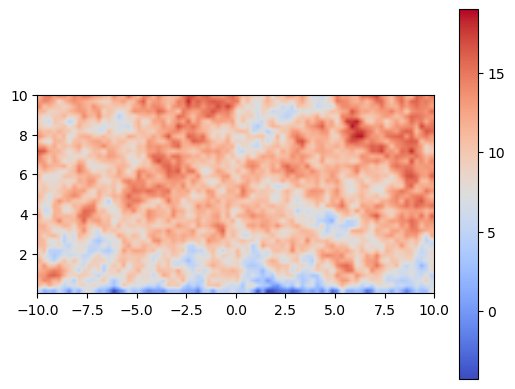

In [5]:
with h5py.File("../../input/pct_turb_ny80_nz40_sonic1_1s.h5", "r") as fp:   
# with h5py.File(filename, "r") as fp:
    print(fp["time_index"][:])  
    # yy_mesh, zz_mesh = np.meshgrid(fp["y_coordinates"][:], fp["z_coordinates"][:])
    # cbar = plt.scatter(yy_mesh, zz_mesh, c=fp["u"][0, :, :], s=60) #, vmin=0.5, vmax=2.7)
    # plt.colorbar(cbar)
    # plt.axis("equal")

    y_fp = fp["y_coordinates"][:]
    z_fp = fp["z_coordinates"][:]

    fig, ax = plt.subplots()
    plt.imshow(fp["u"][0, :, :],  # imshow requires nz-ny slice
                origin='lower',  # smallest y-z in lower left, not upper left
                extent=[y_fp[0], y_fp[-1], z_fp[0], z_fp[-1]],  # lateral and vertical limits
                interpolation='bilinear',
                cmap='coolwarm')  # image smoothing
    plt.colorbar()

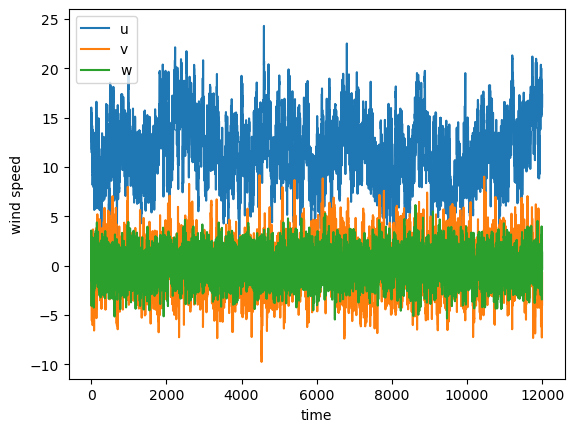

In [6]:
with h5py.File("pct_turb_sonic1_10min.h5", "r") as fp:   
# with h5py.File(filename, "r") as fp:
    plt.plot(fp["u"][:, 10, 20], label='u')
    plt.plot(fp["v"][:, 10, 20], label='v')
    plt.plot(fp["w"][:, 10, 20], label='w')
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('wind speed')


In [1]:
%reset -f

import dolfinx
import gmsh
import numpy as np
import ufl
import h5py
import time

import scipy.interpolate as interp

from petsc4py import PETSc

from mpi4py import MPI

comm = MPI.COMM_WORLD

ndim = 3

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)

domain = gmsh.model.occ.addBox(0, -10.0, 0.0, 10.0, 20.0, 10.0)

gmsh.model.occ.removeAllDuplicates()
gmsh.model.occ.synchronize()

all_points = gmsh.model.getEntities(0)
gmsh.model.mesh.setSize(all_points, 0.5)

gmsh.model.mesh.generate(ndim)

vol_tag_list = gmsh.model.occ.getEntities(ndim)

for k, vol_tag in enumerate(vol_tag_list):
    vol_id = vol_tag[1]
    gmsh.model.add_physical_group(ndim, [vol_id], k+1)

surf_tag_list = gmsh.model.occ.getEntities(ndim-1)

for k, surf_tag in enumerate(surf_tag_list):
    surf_id = surf_tag[1]
    gmsh.model.add_physical_group(ndim-1, [surf_id], k+1)
        
mesh, cell_tags, facet_tags = dolfinx.io.gmshio.model_to_mesh(gmsh.model, comm, 0, gdim=ndim)
gmsh.finalize()


ve_2 = ufl.VectorElement("Lagrange", mesh.ufl_cell(), degree=2)
V = dolfinx.fem.FunctionSpace(mesh, ve_2)

inflow_vel_fn = dolfinx.fem.Function(V, name="inflow_vel_fn")
u = dolfinx.fem.Function(V, name="velocity")



class TurbInflowVelocity:
    def __init__(self, current_time, h5_filename, inflow_dofs):
        self.current_time = current_time
        
        with h5py.File(h5_filename, "r") as fp:
            self.time_index = fp["time_index"][:]
            self.y_coordinates = fp["y_coordinates"][:]
            self.z_coordinates = fp["z_coordinates"][:]
            self.u = fp["u"][:]
            self.v = fp["v"][:]
            self.w = fp["w"][:]
        
        # Create the known axes for our interpolators (t0, z0, y0)
        x0 = (self.time_index, self.z_coordinates, self.y_coordinates)
        
        self.interp_u = interp.RegularGridInterpolator(x0, self.u, bounds_error=False, fill_value=None)
        self.interp_v = interp.RegularGridInterpolator(x0, self.v, bounds_error=False, fill_value=None)
        self.interp_w = interp.RegularGridInterpolator(x0, self.w, bounds_error=False, fill_value=None)
        
        print('np.shape(interp_u) = ', np.shape(self.interp_u))

        self.inflow_dofs = inflow_dofs

        self.inflow_t_final = self.time_index[-1]
        print('inflow_t_final = ', self.inflow_t_final)
        
    def __call__(self, x):
        # Preallocated velocity vector that we will fill
        inflow_velocity = np.zeros((3, x.shape[1]), dtype=PETSc.ScalarType)
        
        # We will interpolate at these (z, y) points,
        # but need to know the current time, too
        
        xi_0_mask = x[0] < 1e-5      
        ti = self.current_time * np.ones(np.sum(xi_0_mask))
        if self.current_time == 0.0:
            print('np.shape(x) = ', np.shape(x))
            print('np.shape(xi_0_mask) = ', np.shape(xi_0_mask))
            print('np.shape(ti) = ', np.shape(ti))
        
#         print("inflow_mask", np.sum(xi_0_mask))
#         print("dofs", len(self.inflow_dofs))

        # ?? is there a way to do this step without the x mask? seems redundant in pvade
        xi = np.vstack((ti, x[2][xi_0_mask], x[1][xi_0_mask])).T

        if self.current_time == 0.0:
            print('np.shape(xi) = ', np.shape(xi))
        
        u_vel = self.interp_u(xi) # ?? this grabs u,v,w at current time?
        v_vel = self.interp_v(xi)
        w_vel = self.interp_w(xi)

        if self.current_time == 0.0:
            print('np.shape(u_vel) = ', np.shape(u_vel))
        
        inflow_velocity[0, xi_0_mask] = u_vel
        inflow_velocity[1, xi_0_mask] = v_vel
        inflow_velocity[2, xi_0_mask] = w_vel
        
        return inflow_velocity


def _inflow_entities(x):
    eps = 1.0e-5

    x_edge = x[0] < eps

    return x_edge

inflow_entities = dolfinx.mesh.locate_entities_boundary(mesh, ndim-1, _inflow_entities)
inflow_dofs = dolfinx.fem.locate_dofs_topological(V, ndim-1, inflow_entities)

# turb_inflow_velocity = TurbInflowVelocity(0.0, "turb_data.h5", inflow_dofs)
turb_inflow_velocity = TurbInflowVelocity(0.0, "pct_turb_data.h5", inflow_dofs)
# turb_inflow_velocity = TurbInflowVelocity(0.0, "pct_turb_sonic1_10min.h5", inflow_dofs)
inflow_vel_fn.interpolate(turb_inflow_velocity) # like another solve, calls the __call__ function to figure out values at the rest of the timesteps


bcs = []
bcs.append(dolfinx.fem.dirichletbc(inflow_vel_fn, inflow_dofs))

dt = 0.1
t_final = 10.0
t_steps = int(t_final/dt)

tic = time.time()

for k in range(t_steps):
    if k == 0:
        with dolfinx.io.XDMFFile(comm, "applied_bcs.xdmf", "w") as xdmf_file:
            xdmf_file.write_mesh(mesh)
    
    current_time = k*dt
    turb_inflow_velocity.current_time = current_time
    inflow_vel_fn.interpolate(turb_inflow_velocity)
#     print(f"Interpolating at t = {current_time:.3f}")
    
    dolfinx.fem.petsc.set_bc(u.vector, bcs)
    
    with dolfinx.io.XDMFFile(comm, "applied_bcs.xdmf", "a") as xdmf_file:
        xdmf_file.write_function(u, current_time)

toc = time.time()

print(f"Elapsed Time = {toc-tic:.3f}s")

np.shape(interp_u) =  ()
inflow_t_final =  9.8
np.shape(x) =  (3, 729560)
np.shape(xi_0_mask) =  (729560,)
np.shape(ti) =  (17262,)
np.shape(xi) =  (17262, 3)
np.shape(u_vel) =  (17262,)
np.shape(x) =  (3, 729560)
np.shape(xi_0_mask) =  (729560,)
np.shape(ti) =  (17262,)
np.shape(xi) =  (17262, 3)
np.shape(u_vel) =  (17262,)
Elapsed Time = 8.237s
